# Numerics Investigation for Far Reaching Horizons

In [ ]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random

In [ ]:
include("../rollout.jl")
include("../testfns.jl")

In [ ]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 5
HORIZON = 1
MC_SAMPLES = 5
BUDGET = 1;

In [ ]:
# Setup toy problem
testfn = TestFunction(
    1, [0. 1.], [.5],
    x -> 0. + 1e-6*randn(),
    ∇x -> [0. + 1e-6*randn()]
)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

In [ ]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
X = [.15, .85]
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...])
sur = fit_surrogate(ψ, X, testfn.f);

In [ ]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

In [ ]:
eis, ∇eis = [], []
# T = nothing
for random_number_stream in [lds_rns, rns]
    rollout_ei = [0 0] # Sample mean and variance tuples
    ∇rollout_ei = [0 0] # Sample mean and variance tuples
    
    println("Total '|'s => $(length(domain))")
    for x0 in domain
        print("|$x0")
        # Grab each input location and convert to a column vector
        x0 = [x0]

        αxs, ∇αxs = [], []
        # Monte-carlo integrate trajectory for x0
        for sample in 1:MC_SAMPLES
            # Make a copy of our surrogate to pass to the trajectory struct
            # for fantasized computations
            fsur = Base.deepcopy(sur)
            fantasy_ndx = size(fsur.X, 2) + 1

            # Rollout trajectory
            T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON, fopt=minimum(sur.y))
            rollout!(T, lbs, ubs; rnstream=random_number_stream[sample,:,:])

            # Evaluate rolled out trajectory
            push!(αxs, α(T))
            push!(∇αxs, first(∇α(T)))
        end # endfor sample

        # Average trajectories
        μx = sum(αxs) / length(αxs)
        ∇μx = sum(∇αxs) / length(αxs)
        σx = sum((αxs .- μx) .^ 2) / (MC_SAMPLES-1)
        ∇σx = sum((∇αxs .- ∇μx) .^ 2) / (MC_SAMPLES-1)

        # Update history
        # sx = sur(x0)
        # μx += ei(sx.μ, sx.σ, minimum(sur.y)) + poi(sx.μ, sx.σ, minimum(sur.y))
        rollout_ei = vcat(rollout_ei, [μx σx])
        ∇rollout_ei = vcat(∇rollout_ei, [∇μx ∇σx])
    end # endfor x0
    rollout_ei = rollout_ei[2:end, :]
    ∇rollout_ei = ∇rollout_ei[2:end, :];
    
    push!(eis, rollout_ei)
    push!(∇eis, ∇rollout_ei)
end

Total '|'s => 99
|0.0|0.01|0.02|0.03InterruptException()
|0.04|0.05

In [ ]:
plot(
    domain,
    [T.s([x]).μ for x in domain],
    ribbons=2*[T.s([x]).σ for x in domain]
)
scatter!(T.s.X', T.s.y)

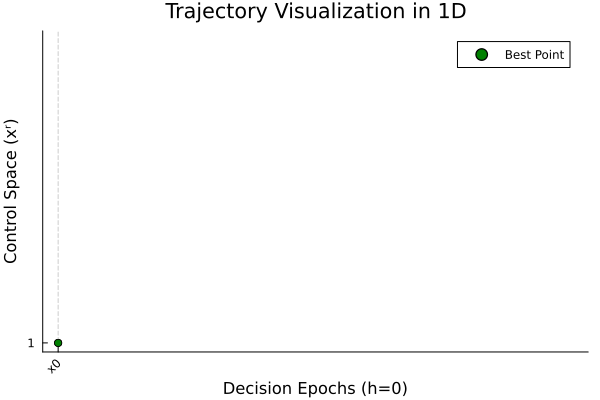

In [11]:
visualize1D(T)